In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
FILE_PATH = 'https://raw.githubusercontent.com/AHMerrill/Unstructured-Data-1/main/car_comments_zm.csv'
COMMENT_BIN = 'comment'

comments_df = pd.read_csv(FILE_PATH)

# --- clean the text column: drop NaNs/empties, ensure strings ---
texts = (
    comments_df[COMMENT_BIN]
      .dropna()            # remove NaNs
      .astype(str)         # force to string (after dropna to avoid 'nan' strings)
      .str.strip()
)
texts = texts[texts != ""]  # drop empty strings

vectorizer = CountVectorizer(lowercase = True, stop_words = None)
X = vectorizer.fit_transform(texts)

word_counts = np.asarray(X.sum(axis = 0)).ravel()
vocab = np.array(vectorizer.get_feature_names_out())

zipf_df = pd.DataFrame({'word':vocab,'count':word_counts})
zipf_df = zipf_df.sort_values('count', ascending = False).reset_index(drop = True)
zipf_df['rank'] = np.arange(1,len(zipf_df)+1)

zipf_df['log_rank'] = np.log(zipf_df['rank'])
zipf_df['log_count'] = np.log(zipf_df['count'])

zipf_df

,word,count,rank,log_rank,log_count
0,the,52349,1,0.000000,10.865688
1,and,20788,2,0.693147,9.942131
2,to,20122,3,1.098612,9.909569
3,is,15571,4,1.386294,9.653165
4,of,14327,5,1.609438,9.569901
...,...,...,...,...,...
41830,zerofun,1,41831,10.641393,0.000000
41831,zerodont,1,41832,10.641417,0.000000
41832,zing,1,41833,10.641441,0.000000
41833,zhpi,1,41834,10.641465,0.000000


In [4]:
X = sm.add_constant(zipf_df['log_rank']) # predictor = log(rank)
y = zipf_df['log_count'] # response = log(count)

model = sm.OLS(y, X).fit(cov_type = 'HC1')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                 5.079e+05
Date:                Thu, 04 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:39:43   Log-Likelihood:                -9029.0
No. Observations:               41835   AIC:                         1.806e+04
Df Residuals:                   41833   BIC:                         1.808e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7136      0.017    756.316      0.0

## The confidence interval for the log_rank coefficient does **NOT** include -1.  This means that there is not an exact -1 relationship between log_rank and log_count.  Zipf's law doesn't hold _exactly_, but there is still strong evidence of a power-law fit

In [5]:
slope_hat = model.params['log_rank']
se = model.bse['log_rank']
t_stat = (slope_hat + 1) / se # because null hypothesis: slope = -1
dfree = model.df_resid
from scipy.stats import t as tdist
pval = 2* (1-tdist.cdf(abs(t_stat), dfree))

print(f"\nSlope estimate: {slope_hat:.4f}")
print(f"Std error: {se:.4f}")
print(f"T-stat vs -1: {t_stat:.2f}, p-value = {pval:.4g}")


Slope estimate: -1.2424
Std error: 0.0017
T-stat vs -1: -139.05, p-value = 0


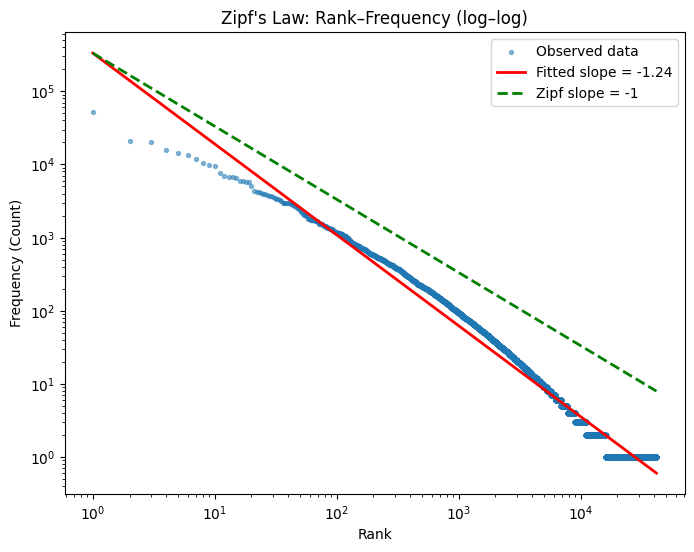

In [7]:
# Regression parameters
a = model.params["const"]
b = model.params["log_rank"]

# Range of ranks to plot
rline = np.linspace(zipf_df["rank"].min(), zipf_df["rank"].max(), 500)

# Fitted regression line
fitted = np.exp(a + b * np.log(rline))

# Reference Zipf line with slope = -1
zipf_ref = np.exp(a - 1 * np.log(rline))

# --- Plot ---
plt.figure(figsize=(8,6))
plt.scatter(zipf_df["rank"], zipf_df["count"], s=8, alpha=0.5, label="Observed data")
plt.plot(rline, fitted, color="red", lw=2, label=f"Fitted slope = {b:.2f}")
plt.plot(rline, zipf_ref, color="green", linestyle="--", lw=2, label="Zipf slope = -1")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Rank")
plt.ylabel("Frequency (Count)")
plt.title("Zipf's Law: Rank–Frequency (log–log)")
plt.legend()
plt.show()